In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.special as sps
from scipy import *
import warnings
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy import stats
import statsmodels.api as sm

In [74]:
df_abgr = pd.read_csv('ABgroup.csv').drop_duplicates(subset = 'user_id')
df_cheat = pd.read_csv('Cheaters.csv').drop_duplicates(subset = 'user_id')
df_pltfrm = pd.read_csv('Platforms.csv').drop_duplicates(subset = 'user_id')
df_money = pd.read_csv('Money.csv')
df_cash = pd.read_csv('Cash.csv')

In [75]:
apc = pd.merge(df_abgr, df_pltfrm, on = 'user_id')
apc = apc.merge(df_cheat, on = 'user_id')

In [76]:
mc = pd.merge(df_money, df_cash)

In [77]:
common = pd.merge(mc, apc, on = ['user_id'])

In [78]:
common

,user_id,date,money,cash,group,platform,cheaters
0,N4TS2T-P7YTVX,15.07.2021,1.99,1150,test,PS4,0
1,N4TS2T-P7YTVX,17.07.2021,0.99,1400,test,PS4,0
2,N4TS2T-P7YTVX,13.07.2021,0.99,150,test,PS4,0
3,N4TS2T-P7YTVX,10.07.2021,0.00,800,test,PS4,0
4,N4TS2T-P7YTVX,16.07.2021,0.00,400,test,PS4,0
...,...,...,...,...,...,...,...
8639995,2NLQHQ-BSFSL5,11.07.2021,1.99,1200,test,PC,0
8639996,2NLQHQ-BSFSL5,14.07.2021,1.99,1200,test,PC,0
8639997,2NLQHQ-BSFSL5,16.07.2021,0.99,950,test,PC,0
8639998,2NLQHQ-BSFSL5,17.07.2021,3.99,2850,test,PC,0


In [79]:
df1 = common.groupby('user_id')[['money', 'cash']].sum()
df1 = df1.reset_index()

In [80]:
df2 = df_cheat[df_cheat['cheaters'] == 1].drop_duplicates(subset = 'user_id')
df2.drop('cheaters', axis= 1 , inplace= True)

In [81]:
df3 = pd.merge(df2, df1, on = 'user_id')

In [82]:
df4 = pd.concat([df1, df2], ignore_index= True)
df4 = df4.drop_duplicates(subset = 'user_id', keep = False)

In [83]:
new_cheat = pd.merge(df_money, df_cash)
new_cheat = new_cheat.merge(df_cheat)
new_cheat.drop('date', axis= 1 , inplace= True)
new_cheat = new_cheat.loc[new_cheat['cheaters'] != 1]
new_cheat.drop('cheaters', axis= 1 , inplace= True)
new_cheat = new_cheat.loc[new_cheat['money'] == 0]
new_cheat.drop('money', axis= 1 , inplace= True)
new_cheat = new_cheat.groupby(['user_id'], as_index=False).sum()
new_cheat

,user_id,cash
0,00036L-1T885I,2900
1,0004MK-MRBUKF,2050
2,0004MK-VW0O9L,1500
3,0005S4-UEC6BE,550
4,0007I5-EWUD6O,850
...,...,...
1070526,ZZZPEX-P2T8BH,1350
1070527,ZZZTEN-0QGZ3X,900
1070528,ZZZTR5-QSI6D3,4900
1070529,ZZZV9K-NM9B4Z,2300


In [84]:
Q1 = new_cheat.cash.quantile(0.25)
Q3 = new_cheat.cash.quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - (3 * IQR) 
upper = Q3 + (3 * IQR)
new_cheat = new_cheat[(new_cheat.cash < lower) | (new_cheat.cash > upper)]

In [85]:
len(new_cheat)

374

<Axes: >

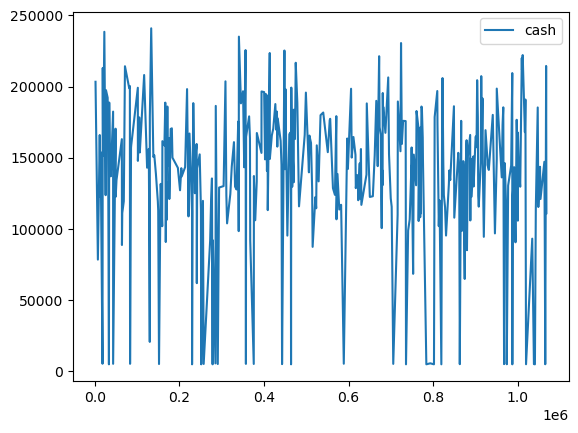

In [86]:
new_cheat.plot()

In [87]:
def confidence_interval(df=new_cheat, column = "cash", alpha = 0.95):
    interval = stats.norm.interval(alpha, loc=df[column].mean(), scale=df[column].std())
    return interval
confidence = confidence_interval()
confidence

(37841.01325121787, 240740.8049306003)

Text(0.5, 1.0, 'Доверительный интервал')

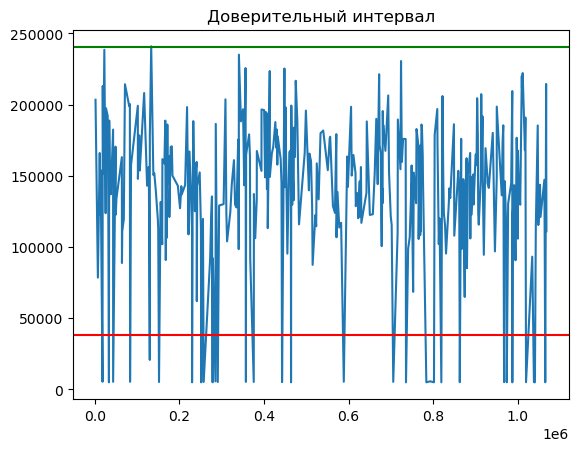

In [88]:
new_cheat.cash.plot()
plt.axhline(y=confidence[1], color="g", linestyle="-")
plt.axhline(y=confidence[0], color="r", linestyle="-")
plt.title("Доверительный интервал")

In [89]:
for i in new_cheat.cash:
    if i < confidence[0]:
        new_cheat = new_cheat[new_cheat.cash != i]

In [90]:
new_cheat

,user_id,cash
1839,027YD0-7N2S50,203400
7426,091QZN-XYWQ8D,78500
11792,0E95BB-LTAHXQ,166000
13557,0GCX0G-5BZ6HE,122650
13659,0GH23F-XS6VSB,152150
...,...,...
1062790,ZQNX2R-TGBYZ0,147200
1063700,ZRQNJL-5G1WXO,97950
1065973,ZUEJJE-KN8O77,121400
1066925,ZVKT51-78VHI9,214500


Text(0.5, 1.0, 'Доверительный интервал')

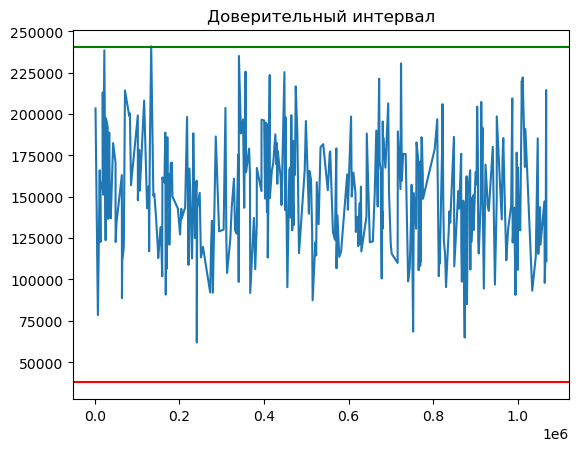

In [91]:
new_cheat.cash.plot()
plt.axhline(y=confidence[1], color="g", linestyle="-")
plt.axhline(y=confidence[0], color="r", linestyle="-")
plt.title("Доверительный интервал")

In [92]:
clean = pd.concat([new_cheat, df4])
clean = clean.drop_duplicates(subset = 'user_id', keep = False)

<Axes: >

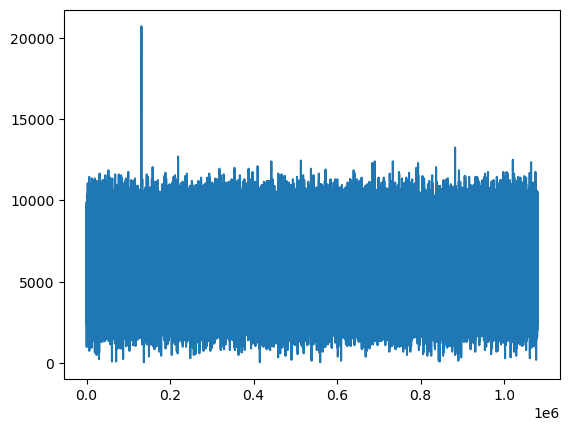

In [93]:
clean.cash.plot()

In [94]:
q1 = clean.cash.quantile(0.25)
q3 = clean.cash.quantile(0.75)
iqr = q3 - q1
low = q1 - (1.5 * iqr) 
up = q3 + (3 * iqr)

In [95]:
q = clean[(clean.cash > up)]
q

,user_id,cash,money
131247,4DBX3L-2LHKON,20700.0,0.00
218951,7AJHSG-INMTKY,12700.0,12.95
882461,TF1GNR-J53YKF,13250.0,15.94


In [96]:
q.max()

user_id    TF1GNR-J53YKF
cash             20700.0
money              15.94
dtype: object

In [97]:
q.loc[q.user_id == '4DBX3L-2LHKON']

,user_id,cash,money
131247,4DBX3L-2LHKON,20700.0,0.0


<Axes: >

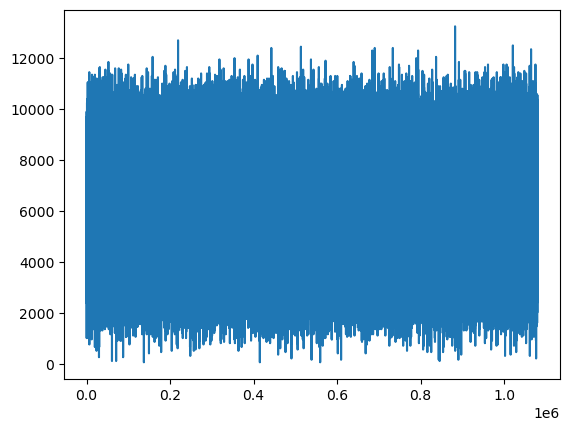

In [98]:
clean = clean[clean.user_id != '4DBX3L-2LHKON']
clean.cash.plot()

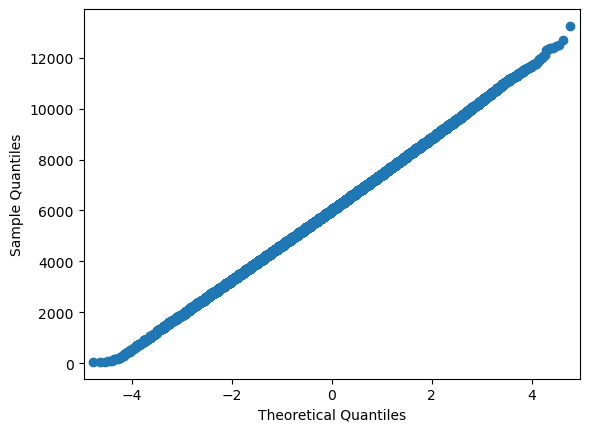

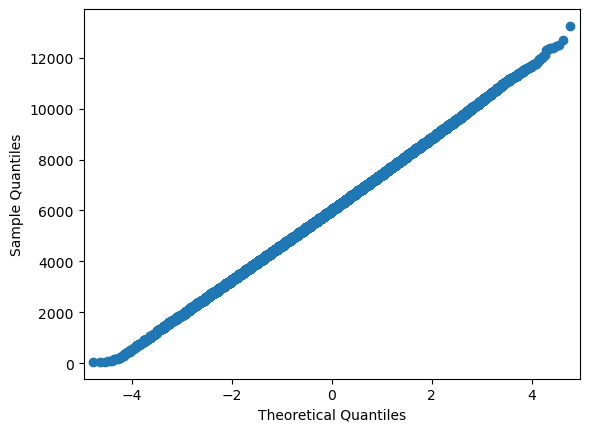

In [99]:
sm.qqplot(clean['cash'])

In [100]:
len(clean)

1079303

In [101]:
common_2 = common.copy()
common_2.drop('date', axis= 1 , inplace= True)
common_2 = common_2.groupby(['user_id', 'group', 'platform'], as_index=False).sum()

In [102]:
common_3 = pd.merge(clean, common_2, on = ['user_id', 'money', 'cash'], how = 'left')
del common_3['cheaters']
common_3

,user_id,cash,money,group,platform
0,00036L-1T885I,7600.0,3.97,control,XBox
1,0004MK-MRBUKF,6150.0,5.95,control,PS4
2,0004MK-VW0O9L,6300.0,4.96,test,PC
3,0005S4-UEC6BE,5000.0,5.95,test,PC
4,0007I5-EWUD6O,6350.0,6.94,test,PC
...,...,...,...,...,...
1079298,ZZZPEX-P2T8BH,6600.0,6.95,test,PC
1079299,ZZZTEN-0QGZ3X,4600.0,5.97,test,XBox
1079300,ZZZTR5-QSI6D3,5900.0,0.99,test,XBox
1079301,ZZZV9K-NM9B4Z,3900.0,3.97,control,PS4


In [103]:
control = common_3.loc[common_3['group'] == 'control']
control

,user_id,cash,money,group,platform
0,00036L-1T885I,7600.0,3.97,control,XBox
1,0004MK-MRBUKF,6150.0,5.95,control,PS4
5,0009DN-TWTJIG,7250.0,5.97,control,XBox
6,000A88-I8NCEL,4500.0,3.97,control,PS4
7,000B68-JX82RN,7200.0,5.95,control,PS4
...,...,...,...,...,...
1079288,ZZZ8PP-DTMHBH,4750.0,2.98,control,PS4
1079295,ZZZL1P-5DBOHS,6550.0,8.94,control,PS4
1079296,ZZZNBN-SJROHK,5450.0,4.95,control,PS4
1079301,ZZZV9K-NM9B4Z,3900.0,3.97,control,PS4


In [104]:
control[['cash', 'money']].mean()

cash     5800.705382
money       5.829478
dtype: float64

In [105]:
test = common_3.loc[common_3['group'] == 'test']
test

,user_id,cash,money,group,platform
2,0004MK-VW0O9L,6300.0,4.96,test,PC
3,0005S4-UEC6BE,5000.0,5.95,test,PC
4,0007I5-EWUD6O,6350.0,6.94,test,PC
13,000IF8-UU506H,5350.0,6.94,test,PS4
16,000IX6-VZLBS1,9900.0,10.95,test,PC
...,...,...,...,...,...
1079294,ZZZIS2-9EYJF3,7100.0,3.96,test,PC
1079297,ZZZONB-1W7QEW,6750.0,6.95,test,PC
1079298,ZZZPEX-P2T8BH,6600.0,6.95,test,PC
1079299,ZZZTEN-0QGZ3X,4600.0,5.97,test,XBox


In [106]:
test[['cash', 'money']].mean()

cash     6229.596319
money       6.162276
dtype: float64

# Доверительные интервалы групп с владельцами PS4

In [107]:
control_ps4 = control.loc[control['platform'] == 'PS4']
test_ps4 = test.loc[test['platform'] == 'PS4']

In [108]:
def conf(df, column):
    intrvl = stats.norm.interval(0.95, loc=df[column].mean(), scale=df[column].std())
    return intrvl

In [109]:
conf_control_ps4 = conf(control_ps4, 'cash')
conf_control_ps4

(3066.57092390516, 8297.3014037405)

In [110]:
conf_test_ps4 = conf(test_ps4, 'cash')
conf_test_ps4

(3460.5664381068054, 8800.420101480186)

# Доверительные интервалы групп с владельцами  XBox

In [111]:
control_xbox = control.loc[control['platform'] == 'XBox']
test_xbox = test.loc[test['platform'] == 'XBox']

In [112]:
conf_control_xbox = conf(control_xbox, 'cash')
conf_control_xbox

(3388.3958264174894, 8875.191217443862)

In [113]:
conf_test_xbox = conf(test_xbox, 'cash')
conf_test_xbox

(3429.8260479286673, 8922.979696280754)

# Доверительные интервалы групп с владельцами  PC

In [114]:
control_pc = control.loc[control['platform'] == 'PC']
test_pc = test.loc[test['platform'] == 'PC']

In [115]:
conf_control_pc= conf(control_pc, 'cash')
conf_control_pc

(3159.7836793857646, 8014.420691566542)

In [116]:
conf_test_pc = conf(test_pc, 'cash')
conf_test_pc

(3527.490304225572, 9236.000964821253)

# 

In [117]:
common_clean = clean.copy()
del common_clean['cash']
del common_clean['money']

In [118]:
common_clean = pd.merge(common_clean, common, on = 'user_id', how = 'left')
common_clean.drop('cheaters', axis= 1 , inplace= True )
common_clean

,user_id,date,money,cash,group,platform
0,00036L-1T885I,10.07.2021,0.00,700,control,XBox
1,00036L-1T885I,16.07.2021,0.99,550,control,XBox
2,00036L-1T885I,11.07.2021,0.00,0,control,XBox
3,00036L-1T885I,12.07.2021,0.99,1500,control,XBox
4,00036L-1T885I,14.07.2021,0.00,650,control,XBox
...,...,...,...,...,...,...
8634419,ZZZVH1-2OJT7I,16.07.2021,0.00,550,control,PC
8634420,ZZZVH1-2OJT7I,13.07.2021,0.99,650,control,PC
8634421,ZZZVH1-2OJT7I,11.07.2021,0.99,150,control,PC
8634422,ZZZVH1-2OJT7I,10.07.2021,0.99,1350,control,PC


In [119]:
# common_clean.to_csv('clean.csv', index= False )

In [120]:
common_3

,user_id,cash,money,group,platform
0,00036L-1T885I,7600.0,3.97,control,XBox
1,0004MK-MRBUKF,6150.0,5.95,control,PS4
2,0004MK-VW0O9L,6300.0,4.96,test,PC
3,0005S4-UEC6BE,5000.0,5.95,test,PC
4,0007I5-EWUD6O,6350.0,6.94,test,PC
...,...,...,...,...,...
1079298,ZZZPEX-P2T8BH,6600.0,6.95,test,PC
1079299,ZZZTEN-0QGZ3X,4600.0,5.97,test,XBox
1079300,ZZZTR5-QSI6D3,5900.0,0.99,test,XBox
1079301,ZZZV9K-NM9B4Z,3900.0,3.97,control,PS4


In [121]:
common_4 = common_3.copy()
del common_4['user_id']

# ARPU

In [122]:
common_4[common_4['group'] == 'control'].groupby('platform').mean('cash', 'money')

,cash,money
platform,,
PC,5587.102185,5.646201
PS4,5681.936164,5.737647
XBox,6131.793522,6.103521


In [123]:
common_4[common_4['group'] == 'test'].groupby('platform').mean('cash', 'money')

,cash,money
platform,,
PC,6381.745635,6.269046
PS4,6130.493270,6.084883
XBox,6176.402872,6.132766


In [135]:
arpu1 = common_4[common_4['group'] == 'control'].groupby('platform', as_index=False).mean('cash', 'money')
arpu1.insert(loc= 3 , column='group', value='control')
arpu2 = common_4[common_4['group'] == 'test'].groupby('platform', as_index=False).mean('cash', 'money')
arpu2.insert(loc= 3 , column='group', value='test')

In [142]:
arpu = pd.concat([arpu1, arpu2], ignore_index= True)
arpu

,platform,cash,money,group
0,PC,5587.102185,5.646201,control
1,PS4,5681.936164,5.737647,control
2,XBox,6131.793522,6.103521,control
3,PC,6381.745635,6.269046,test
4,PS4,6130.493270,6.084883,test
5,XBox,6176.402872,6.132766,test


In [143]:
# arpu.to_excel('ARPU.xlsx', index= False)

# ARPPU

In [124]:
common_4[(common_4['money'] != 0) & (common_4['group'] == 'control')].groupby('platform').mean('cash', 'money')

,cash,money
platform,,
PC,5587.963989,5.648307
PS4,5682.683160,5.739466
XBox,6132.223934,6.104434


In [125]:
common_4[(common_4['money'] != 0) & (common_4['group'] == 'test')].groupby('platform').mean('cash', 'money')

,cash,money
platform,,
PC,6382.064238,6.269743
PS4,6130.925212,6.085866
XBox,6176.848098,6.133686
